In [33]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [34]:
data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

print("Dataset importato con successo")

Dataset importato con successo


Total :  13451
Normal :  7500
Malicious :  5951


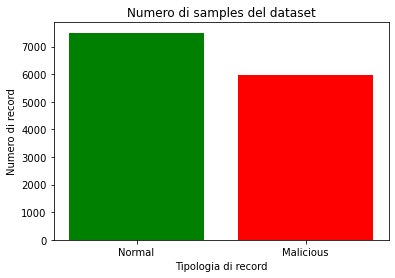

In [35]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [36]:
def preprocessing(data):
    for column in data.columns:
        if data[column].dtype == type(object):
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])

In [37]:
preprocessing(data)

y = data.result
x = data.drop("result", axis=1)

profile = cProfile.Profile()
x_train, x_test, y_train, y_test = splitter(x, y, test_size=0.3, random_state=32)

In [38]:
num_train = len(x_train)
num_train_normal = 0
num_train_dos = 0
num_train_r2l = 0
num_train_u2r = 0
num_train_probe = 0

print("Il dataset per il train è composto da : ",num_train,"record")

for i in y_train:
    if(i == 0):
        num_train_dos = num_train_dos + 1
    if(i == 1):
        num_train_normal = num_train_normal + 1
    if(i == 2):
        num_train_probe = num_train_probe + 1
    if(i == 2):
        num_train_r2l = num_train_r2l + 1
    if(i == 2):
        num_train_u2r = num_train_u2r + 1
    
        
num_train_anomaly = num_train - num_train_normal

print("Il dataset per il train è composto da : ",num_train_anomaly,"anomalie")
print("Il dataset per il train è composto da : ",num_train_normal,"record normali")

Il dataset per il train è composto da :  9415 record
Il dataset per il train è composto da :  4186 anomalie
Il dataset per il train è composto da :  5229 record normali


In [39]:
num_test = len(x_test)
num_test_normal = 0

print("Il dataset per il test è composto da : ",num_test,"record")

for i in y_test:
    if(i == 1):
        num_test_normal = num_test_normal + 1
        
num_test_anomaly = num_test - num_test_normal

print("Il dataset per il test è composto da : ",num_test_anomaly,"anomalie")
print("Il dataset per il test è composto da : ",num_test_normal,"record normali")

Il dataset per il test è composto da :  4036 record
Il dataset per il test è composto da :  1765 anomalie
Il dataset per il test è composto da :  2271 record normali


In [40]:
profile.enable()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
val_indices = 200
x_val = x_train[-val_indices:]
y_val = y_train[-val_indices:]

In [41]:
total = num_train
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / num_train_dos)*(total)/5.0 
weight_for_1 = (1 / num_train_normal)*(total)/5.0
weight_for_2 = (1 / num_train_probe)*(total)/5.0
weight_for_3 = (1 / num_train_r2l)*(total)/5.0
weight_for_4 = (1 / num_train_u2r)*(total)/5.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))

Weight for class 0: 0.54
Weight for class 1: 0.36
Weight for class 2: 4.93
Weight for class 3: 4.93
Weight for class 4: 4.93


In [42]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              22528     
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)             

In [43]:
model.fit(x_train, y_train, epochs=15, batch_size=512, validation_data=(x_val, y_val), class_weight=class_weight)

Epoch 1/15
19/19 [==============================] - 5s 259ms/step - loss: 7.1619 - accuracy: 0.2253 - val_loss: 5.5071 - val_accuracy: 0.4050
Epoch 2/15
19/19 [==============================] - 4s 222ms/step - loss: 4.6397 - accuracy: 0.3903 - val_loss: 4.5892 - val_accuracy: 0.0850
Epoch 3/15
19/19 [==============================] - 4s 221ms/step - loss: 3.7301 - accuracy: 0.4541 - val_loss: 3.6801 - val_accuracy: 0.0700
Epoch 4/15
19/19 [==============================] - 4s 236ms/step - loss: 2.8749 - accuracy: 0.5077 - val_loss: 2.9499 - val_accuracy: 0.4500
Epoch 5/15
19/19 [==============================] - 4s 224ms/step - loss: 2.1870 - accuracy: 0.6163 - val_loss: 2.1954 - val_accuracy: 0.8700
Epoch 6/15
19/19 [==============================] - 4s 224ms/step - loss: 1.7171 - accuracy: 0.7070 - val_loss: 1.4049 - val_accuracy: 0.9050
Epoch 7/15
19/19 [==============================] - 4s 227ms/step - loss: 1.2503 - accuracy: 0.7476 - val_loss: 1.2512 - val_accuracy: 0.5500
Epoch 

In [44]:
y_pred = model.predict(x_test)
profile.disable()
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
profile.dump_stats('output.prof')
stream = open('result/keras_kdd_profiling.txt', 'w')
stats = pstats.Stats('output.prof', stream=stream)
stats.sort_stats('cumtime')
stats.print_stats()
os.remove('output.prof')

Il classificatore ha predetto in totale 1748 record Dos di cui 1462 corretti(TP), 286 predetti erroneamente(FP), 33 record Dos reali predetti in altri attacchi (FN)

Il classificatore ha predetto in totale 2064 record Normali di cui 2035 corretti(TP), 29 predetti erroneamente(FP), 236 record Normali reali predetti in altri attacchi (FN)

Il classificatore ha predetto in totale 88 record Probe di cui 11 corretti(TP), 77 predetti erroneamente(FP), 127 record Probe reali predetti in altri attacchi (FN)

Il classificatore ha predetto in totale 122 record R2L di cui 105 corretti(TP), 17 predetti erroneamente(FP), 11 record R2L reali predetti in altri attacchi (FN)

Il classificatore ha predetto in totale 14 record U2R di cui 10 corretti(TP), 4 predetti erroneamente(FP), 6 record U2R reali predetti in altri attacchi (FN)


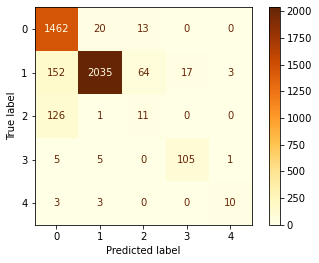

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1495
           1       0.99      0.90      0.94      2271
           2       0.12      0.08      0.10       138
           3       0.86      0.91      0.88       116
           4       0.71      0.62      0.67        16

    accuracy                           0.90      4036
   macro avg       0.70      0.70      0.70      4036
weighted avg       0.90      0.90      0.89      4036



In [45]:
conf_matrix = confusion_matrix(y_test, y_pred)

# 0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

print("Il classificatore ha predetto in totale", 
      conf_matrix[0][0]+conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]+conf_matrix[4][0],
      "record Dos di cui",conf_matrix[0][0],"corretti(TP),",
      conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]+conf_matrix[4][0],
      "predetti erroneamente(FP),",
      conf_matrix[0][1]+conf_matrix[0][2]+conf_matrix[0][3]+conf_matrix[0][4],
      "record Dos reali predetti in altri attacchi (FN)"
     )
print("")
print("Il classificatore ha predetto in totale", 
      conf_matrix[0][1]+conf_matrix[1][1]+conf_matrix[2][1]+conf_matrix[3][1]+conf_matrix[4][1],
      "record Normali di cui",conf_matrix[1][1],"corretti(TP),",
      conf_matrix[0][1]+conf_matrix[2][1]+conf_matrix[3][1]+conf_matrix[4][1],
      "predetti erroneamente(FP),",
      conf_matrix[1][0]+conf_matrix[1][2]+conf_matrix[1][3]+conf_matrix[1][4],
      "record Normali reali predetti in altri attacchi (FN)"
     )
print("")
print("Il classificatore ha predetto in totale", 
      conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[2][2]+conf_matrix[3][2]+conf_matrix[4][2],
      "record Probe di cui",conf_matrix[2][2],"corretti(TP),",
      conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[3][2]+conf_matrix[4][2],
      "predetti erroneamente(FP),",
      conf_matrix[2][0]+conf_matrix[2][1]+conf_matrix[2][3]+conf_matrix[2][4],
      "record Probe reali predetti in altri attacchi (FN)"
     )
print("")
print("Il classificatore ha predetto in totale", 
      conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]+conf_matrix[3][3]+conf_matrix[4][3],
      "record R2L di cui",conf_matrix[3][3],"corretti(TP),",
      conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]+conf_matrix[4][3],
      "predetti erroneamente(FP),",
      conf_matrix[3][0]+conf_matrix[3][1]+conf_matrix[3][2]+conf_matrix[3][4],
      "record R2L reali predetti in altri attacchi (FN)"
     )
print("")
print("Il classificatore ha predetto in totale", 
      conf_matrix[0][4]+conf_matrix[1][4]+conf_matrix[2][4]+conf_matrix[3][4]+conf_matrix[4][4],
      "record U2R di cui",conf_matrix[4][4],"corretti(TP),",
      conf_matrix[0][4]+conf_matrix[1][4]+conf_matrix[2][4]+conf_matrix[3][4],
      "predetti erroneamente(FP),",
      conf_matrix[4][0]+conf_matrix[4][1]+conf_matrix[4][2]+conf_matrix[4][3],
      "record U2R reali predetti in altri attacchi (FN)"
     )

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp = disp.plot(cmap='YlOrBr')

plt.show()
print("0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r")
print("")
print(classification_report(y_test, y_pred))